<ipython-input-4-7e8673e28699>:282: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlGn"))
  current_cmap.set_bad(color='white')
<ipython-input-4-7e8673e28699>:282: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
  current_cmap.set_bad(color='white')


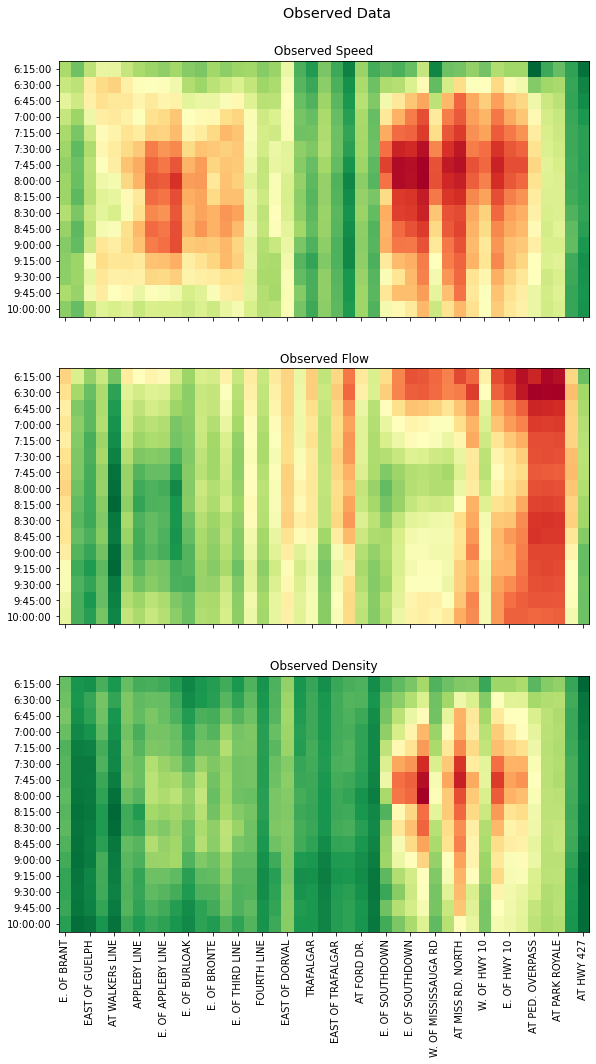

<ipython-input-4-7e8673e28699>:282: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlGn"))
  current_cmap.set_bad(color='white')
<ipython-input-4-7e8673e28699>:282: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
  current_cmap.set_bad(color='white')


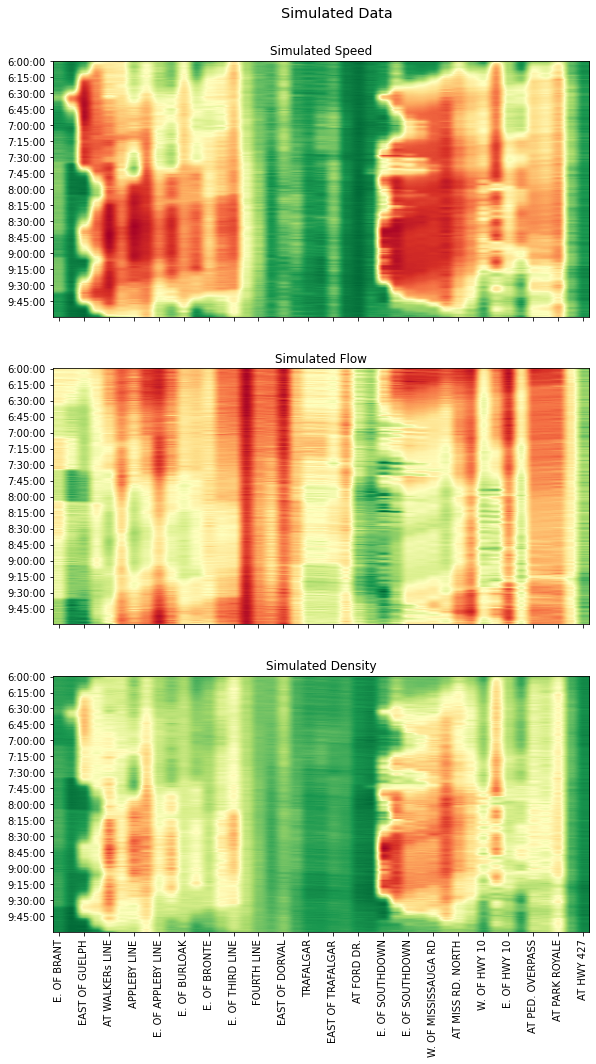

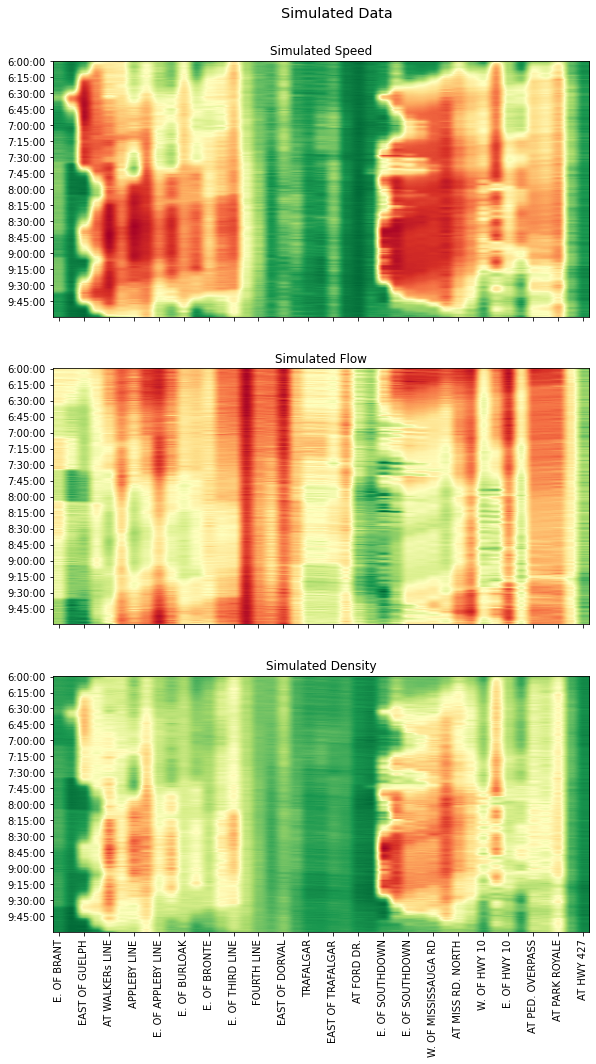

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, IndexLocator
from matplotlib.animation import FuncAnimation
import pandas as pd
import datetime
from math import ceil

startTime = 21600
endTime = 36000
intervalLen = 60
file_sim = 'repl10300398_detectors_VSL_one_lane_no_acce.csv'
file_obs = 'ITSoS_detectors.csv'

def readData(detectorFileName, detectors=None, intervals=None):
    '''
    

    Parameters
    ----------
    detectorFileName : TYPE
        DESCRIPTION.
    detectors : TYPE, optional
        ['QEWDE0010DES','QEWDE0020DES']. The default is None.
    intervals : TYPE, optional
        range(5*4,22*4). The default is None.

    Returns
    -------
    None.

    '''
    df = pd.read_csv(detectorFileName)
    if detectors:
        df=df[df['eid'].isin(detectors)]
    if intervals:
        df=df[df['interval'].isin(intervals)]
    df.sort_values(['eid', 'interval'])
    return df
    
def equate_df_keys(df1, df2, key):
    '''
    

    Parameters
    ----------
    df1 : TYPE
        DESCRIPTION.
    df2 : TYPE
        DESCRIPTION.
    key : TYPE
        DESCRIPTION.

    Returns
    -------
    df1_new : TYPE
        DESCRIPTION.
    df2_new : TYPE
        DESCRIPTION.

    '''
    keys1 = df1.groupby(key).groups.keys()
    keys2 = df2.groupby(key).groups.keys()
    #list(set(keys1).symmetric_difference(set(keys2)))
    missing_keys1 = list(set(keys1) - set(keys2))
    if missing_keys1:
        df1_new = df1[~ df1[key].isin(missing_keys1)]
    else:
        df1_new = df1
    missing_keys2 = list(set(keys2) - set(keys1))
    if missing_keys2:
        df2_new = df2[~ df2[key].isin(missing_keys2)]
    else:
        df2_new = df2
    return df1_new, df2_new

'''
#continous heatmap for temporal video
arr = np.arange(100, dtype=float).reshape(10, 10)
arr[~(arr % 7).astype(bool)] = np.nan
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
plt.imshow(arr)
'''    
def heatmap(ax, title, df, statName, limits=None, cmap_reverse=False):
    '''
    

    Parameters
    ----------
    ax : TYPE
        DESCRIPTION.
    title : TYPE
        DESCRIPTION.
    df : TYPE
        DESCRIPTION.
    statName : TYPE
        DESCRIPTION.
    limits : TYPE, optional
        DESCRIPTION. The default is None.
    cmap_reverse : TYPE, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''
    noIntervals = df['interval'].max() + 1
    noDetectors = df['eid'].nunique()
    g = df.groupby('interval').cumcount()
    stat = np.array(df.set_index(['interval',g]).unstack(fill_value=0).stack()
                 .groupby(level=0).apply(lambda x: x[statName].tolist()).tolist())
    locations = [x.split('-')[-1].strip() for x in 
                 df.groupby('eid').apply(lambda x:x['location'].iloc[0])]
    
    # Observed vs. Simulated Time-Space Diagrams of Speed
    def format_fn(tick_val, tick_pos):
    	if tick_val < len(locations):
    		return locations[int(tick_val)]
    	else:
    		return ''
    def format_fny(tick_val, tick_pos):
        timeIntervals = pd.unique(df['time']).tolist()
        if tick_val < len(timeIntervals):
            return timeIntervals[int(tick_val)]
        else:
            return ''
    
    if cmap_reverse:
        cmap = 'RdYlGn_r'
    else:
        cmap = 'RdYlGn'
    current_cmap = matplotlib.cm.get_cmap(cmap)
    current_cmap.set_bad(color='white')
    if limits is None:
        retVal = ax.imshow(stat, cmap=cmap)
    else:
        retVal = ax.imshow(stat, cmap=cmap, vmin=limits[0], vmax=limits[1])
    ax.set_aspect('auto')
    ax.set_title(title)
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.xaxis.set_major_locator(IndexLocator(base=1, offset=0.5))
    for tick in ax.get_xticklabels():
    	tick.set_rotation(90)
        
    ax.yaxis.set_major_formatter(FuncFormatter(format_fny))
    ax.yaxis.set_major_locator(IndexLocator(base=4, offset=0.5))
    
    return retVal

def compare_heatmaps(suptitle, titles, dfs, statName, limits=None, cmap_reverse=False):
    '''
    

    Parameters
    ----------
    titles : TYPE
        DESCRIPTION.
    dfs : TYPE
        DESCRIPTION.
    statName : TYPE
        DESCRIPTION.
    limits : TYPE, optional
        DESCRIPTION. The default is None.
    cmap_reverse : TYPE, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    None.

    '''
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,15), sharex=True) #, subplot_kw={'yticks': range(0,noIntervals,2)})
    st = fig.suptitle(suptitle, fontsize="x-large")
    st.set_y(1)
    
    if limits is None:
        limits = (min(dfs[0][statName].min(), dfs[1][statName].min()),
                  max(dfs[0][statName].max(), dfs[1][statName].max()))
    img = heatmap(ax1, titles[0], dfs[0], statName, 
                  limits=limits, cmap_reverse=cmap_reverse)
    img = heatmap(ax2, titles[1], dfs[1], statName, 
                  limits=limits, cmap_reverse=cmap_reverse)
    plt.tight_layout(pad=3)
    fig.subplots_adjust(right=0.85, top=0.95)
    cbar_ax = fig.add_axes([0.9, 0.25, 0.03, 0.5])
    fig.colorbar(img, cax=cbar_ax)
    plt.show()
    
    return fig

def plot_series(x, y, y_titles, suptitle, 
                xaxis_title=None, yaxis_title=None, 
                plot_type='line'):
    
    # for bar chart
    x1 = np.arange(len(x))  # the label locations
    width = 0.35
    i = 1-len(y)
    
    fig, ax = plt.subplots()
    for series in y:
        if plot_type == 'line':
            ax.plot(x, series)
        elif plot_type == 'bar':
            ax.bar(x1+i*width/2, series, width)
            i += 2
    
    if plot_type == 'line':
        ax.xaxis.set_major_locator(IndexLocator(base=4, offset=0))
        ax.grid(True)
    elif plot_type == 'bar':
        ax.set_xticks(x1)
        ax.set_xticklabels(x)
        #ax.xaxis.set_major_locator(IndexLocator(base=len(y), offset=0))
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_xlabel(xaxis_title)
    ax.set_ylabel(yaxis_title)
    plt.legend(y_titles, loc='best')
    st = fig.suptitle(suptitle, fontsize="x-large")
    st.set_y(1)
    #fig.subplots_adjust(top=0.95)
    plt.show()

#=============================================================================
# New figures
##=============================================================================
def heatmap_single(ax, df, title='', x_labels=None, y_labels=None, 
                   limits=None, cmap_reverse=False):
    '''
    

    Parameters
    ----------
    ax : TYPE
        DESCRIPTION.
    df : TYPE
        DESCRIPTION.
    title : TYPE, optional
        DESCRIPTION. The default is ''.
    x_labels : TYPE, optional
        DESCRIPTION. The default is None.
    y_labels : TYPE, optional
        DESCRIPTION. The default is None.
    limits : TYPE, optional
        DESCRIPTION. The default is None.
    cmap_reverse : TYPE, optional
        DESCRIPTION. The default is False.

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''
    # Observed vs. Simulated Time-Space Diagrams of Speed
    def format_fnx(tick_val, tick_pos):
    	if tick_val < len(x_labels):
    		return x_labels[int(tick_val)]
    	else:
    		return ''
    def format_fny(tick_val, tick_pos):
    	if tick_val < len(y_labels):
    		return y_labels[int(tick_val)]
    	else:
    		return ''
    # default args
    if y_labels is None:
        y_labels = list(df.columns)
    if x_labels is None:
        x_labels = list(df.index)
    if cmap_reverse:
        cmap = 'RdYlGn_r'
    else:
        cmap = 'RdYlGn'
    current_cmap = matplotlib.cm.get_cmap(cmap)
    current_cmap.set_bad(color='white')
    if limits is None:
        img = ax.imshow(df, cmap=cmap, aspect='auto')
    else:
        img = ax.imshow(df, cmap=cmap, aspect='auto', 
                        vmin=limits[0], vmax=limits[1])
    ax.set_title(title)
    ax.xaxis.set_major_formatter(FuncFormatter(format_fnx))
    ax.xaxis.set_major_locator(IndexLocator(base=2, offset=0.5))
    for tick in ax.get_xticklabels():
    	tick.set_rotation(90)
        
    ax.yaxis.set_major_formatter(FuncFormatter(format_fny))
    #ax.yaxis.set_major_locator(IndexLocator(base=1, offset=0.5))
    ax.yaxis.set_major_locator(IndexLocator(base=ceil(len(y_labels)/16), offset=0.5))
    
    return img

def heatmap_grid(dfs, suptitle='', titles=[''], x_labels=None, y_labels=None, 
                 limits=None, cmap_reverse_s=[False],
                 nrows=1, ncols=1, legend=True):
    '''
    

    Parameters
    ----------
    dfs : TYPE
        DESCRIPTION.
    suptitle : TYPE, optional
        DESCRIPTION. The default is ''.
    titles : TYPE, optional
        DESCRIPTION. The default is [''].
    x_labels : TYPE, optional
        DESCRIPTION. The default is None.
    y_labels : TYPE, optional
        DESCRIPTION. The default is None.
    limits : TYPE, optional
        DESCRIPTION. The default is None.
    cmap_reverse : TYPE, optional
        DESCRIPTION. The default is False.
    nrows : TYPE, optional
        DESCRIPTION. The default is 1.
    ncols : TYPE, optional
        DESCRIPTION. The default is 1.

    Returns
    -------
    fig : TYPE
        DESCRIPTION.

    '''
    if nrows == 1 and ncols==1:
        fig, axs = plt.subplots(nrows=1, ncols=1)
        if suptitle == '':
            title = titles[0]
        else:
            title = suptitle
        img = heatmap_single(ax=axs, df=dfs[0], title=title, 
                             x_labels=x_labels, y_labels=y_labels, 
                             limits=limits, cmap_reverse=cmap_reverse_s[0])
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                                 sharex=True,figsize=(10,15))
        # subplot_kw={'yticks': range(0,noIntervals,2)})
        for ax, df, title, cmap_reverse in zip(axs.ravel(), dfs, titles, cmap_reverse_s):
            img = heatmap_single(ax=ax, df=df, title=title, 
                                 x_labels=x_labels, y_labels=y_labels, 
                                 limits=limits, cmap_reverse=cmap_reverse)
        st = fig.suptitle(suptitle, fontsize="x-large")
        st.set_y(1)
    
    plt.tight_layout(pad=3)
    fig.subplots_adjust(right=0.85, top=0.95)
    if legend:
        cbar_ax = fig.add_axes([0.9, 0.25, 0.03, 0.5])
        fig.colorbar(img, cax=cbar_ax)
    plt.show()
    return fig

def heatmap_animated(dfs, suptitle='', titles=[''], 
                     x_labels=None, y_labels=None,
                     limits=None, cmap_reverse=False,
                     nrows=1, ncols=1, save_to=None):
    '''
    

    Parameters
    ----------
    dfs : TYPE
        DESCRIPTION.
    suptitle : TYPE, optional
        DESCRIPTION. The default is ''.
    titles : TYPE, optional
        DESCRIPTION. The default is [''].
    x_labels : TYPE, optional
        DESCRIPTION. The default is None.
    y_labels : TYPE, optional
        DESCRIPTION. The default is None.
    limits : TYPE, optional
        DESCRIPTION. The default is None.
    cmap_reverse : TYPE, optional
        DESCRIPTION. The default is False.
    nrows : TYPE, optional
        DESCRIPTION. The default is 1.
    ncols : TYPE, optional
        DESCRIPTION. The default is 1.
    save_to : TYPE, optional
        DESCRIPTION. The default is None.

    Returns
    -------
    img : TYPE
        DESCRIPTION.
    axs : TYPE
        DESCRIPTION.

    '''
    # TO DO: support two heatmaps above each other
    def update(i):
        label = 'timestep {0}'.format(i)
        print(label)
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        img = heatmap_single(ax=axs, df=dfs[i], title=titles[i],
                             x_labels=x_labels, y_labels=y_labels,
                             limits=limits, cmap_reverse=cmap_reverse)
        #ax.set_xlabel(label)
        return img, axs
    
    fig, axs = plt.subplots(nrows=1, ncols=1)
    if suptitle == '':
        title = titles[0]
    else:
        title = suptitle
    fig.set_tight_layout(True)
    # Query the figure's on-screen size and DPI. Note that when saving the figure to
    # a file, we need to provide a DPI for that separately.
    print('fig size: {0} DPI, size in inches {1}'.format(
        fig.get_dpi(), fig.get_size_inches()))
    
    # Plot a scatter that persists (isn't redrawn) and the initial line.
    '''img = heatmap_single(ax=axs, df=dfs[0], title=title, 
                         x_labels=x_labels, y_labels=y_labels, 
                         limits=limits, cmap_reverse=cmap_reverse)'''
    
    
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=len(dfs), interval=2000)
    if save_to is not None:
        anim.save(save_to, dpi=80, writer='imagemagick')
    else:
        # plt.show() will just loop the animation forever.
        plt.show()
        
def process_all_lanes(df, locations=None, intervals=None):
    detectors = list(df.groupby('eid').groups)
    if locations is None:
        locations = [x.split('-')[-1].strip() for x in 
                     df.groupby('eid').apply(lambda x:x['location'].iloc[0])]
    if intervals is None:
        intervals = [x for x in 
                     df.groupby('interval').apply(lambda x:x['time'].iloc[0])]
    
    speed = df.pivot(index='interval',
                     columns='eid',
                     values='speed')
    speed = speed.reindex(sorted(speed.columns), axis=1)
    
    flow = df.pivot(index='interval',
                    columns='eid',
                    values='flow_per_lane')
    flow = flow.reindex(sorted(flow.columns), axis=1)
    
    density = df.pivot(index='interval',
                       columns='eid',
                       values='density_per_lane')
    density = density.reindex(sorted(density.columns), axis=1)
    
    return detectors, intervals, locations, speed, flow, density

def process_stats(df, locations=None, intervals=None):
    detectors = list(df.groupby('eid').groups)
    if locations is None:
        locations = [x.split('-')[-1].strip() if not pd.isna(x) else '' for x in 
                     df.groupby('eid').apply(lambda x:x['location'].iloc[0])]
    if intervals is None:
        intervals = [x for x in 
                     df.groupby('interval').apply(lambda x:x['time'].iloc[0])]
    
    speed = df.pivot(index='interval',
                     columns='eid',
                     values='speed')
    speed = speed.reindex(sorted(speed.columns), axis=1)
    
    flow = df.pivot(index='interval',
                    columns='eid',
                    values='flow_per_lane')
    flow = flow.reindex(sorted(flow.columns), axis=1)
    
    density = df.pivot(index='interval',
                       columns='eid',
                       values='density_per_lane')
    density = density.reindex(sorted(density.columns), axis=1)
    
    return detectors, intervals, locations, speed, flow, density

def update_number_of_lanes(df, number_of_lanes_df, hov=True, dropna=True,
                           update_stats=True):
    '''
    Updates number of lanes of each detector in df based on number_of_lanes_df

    Parameters
    ----------
    df : pandas.DataFrame
        DESCRIPTION.
    number_of_lanes_df : pandas.DataFrame
        DESCRIPTION.
    hov : bool, optional
        DESCRIPTION. The default is True.
    dropna : bool, optional
        DESCRIPTION. The default is True.
    update_stats : bool, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    result : TYPE
        DESCRIPTION.

    '''
    number_of_lanes_df.drop_duplicates(['eid'], keep='first', inplace=True)
    result = df.merge(number_of_lanes_df, 'left', on='eid', suffixes=('','_y'))
    result['number_of_lanes'] = result.apply(lambda x:x['number_of_lanes_y'], 
                                             axis=1)
    result = result.drop(columns=['number_of_lanes_y'])
    if hov:
        result['number_of_lanes'] = result.apply(lambda x:1 if x['station_num_2']==1 \
                                                 else x['number_of_lanes'], axis=1)
    if dropna:
        result.dropna(subset=['number_of_lanes'], inplace=True)
    if update_stats:
        result['flow_per_lane'] = result.apply(
            lambda x:x['flow']/x['number_of_lanes'] \
                if x['number_of_lanes']!=0 else None, 
                axis=1)
        result['density_per_lane'] = result.apply(
            lambda x:x['flow_per_lane']/x['speed'] \
                if x['number_of_lanes']!=0 else None, 
                axis=1)
    return result
    
def update_hov_locations(df):
    locations = df[df.station_num_2==0].groupby('station_num').\
                    apply(lambda x:x['location'].iloc[0])
    locations = df[df.station_num_2==0][['station_num','location']]
    locations.drop_duplicates(['station_num'], keep='first', inplace=True)
    result = df.merge(locations, 'left', on='station_num', suffixes=('','_y'))
    result['location'] = result.apply(lambda x:x['location_y'], axis=1)
    result = result.drop(columns=['location_y'])
    return result
    
# Observed Data
#==============
# observed data 2016
#___________________
df_obs = pd.read_csv(file_obs)
#detectors, intervals, locations, speed_obs, flow_obs, density_obs = \
#    process_all_lanes(df_obs)
detectors, intervals, locations, speed_obs, flow_obs, density_obs = \
    process_stats(df_obs)
#heatmap_grid(dfs=[speed_obs], suptitle='Observed Speed', 
#             x_labels=locations, y_labels=intervals)
heatmap_grid(dfs=[speed_obs, flow_obs, density_obs], suptitle='Observed Data',
             titles=['Observed Speed', 'Observed Flow', 'Observed Density'],
             x_labels=locations, y_labels=intervals, legend=False,
             nrows=3, ncols=1, cmap_reverse_s=[False, True, True])
# Simulated Data
#==============
intervals = [str(datetime.timedelta(seconds=i)) for i in range(startTime, endTime, intervalLen)]
df_sim = pd.read_csv(file_sim)
df_sim.insert(loc=2, column='lane',
              value=df_sim.apply(lambda row: int(row['name'].split('_')[-1]) \
                                 if len(row['name'].split('_'))>1 else -1,
                                 axis=1))
df_sim.insert(loc=2, column='eid',
              value=df_sim.apply(lambda row: row['name'].split('_')[0], axis=1))
df_by_lane = df_sim[df_sim.lane != -1]
df_all_lanes = df_sim[df_sim.lane == -1]
# all lanes
#__________
# reuse intervals from "observed data" section
# check this
#_, _, _, speed_sim, flow_sim, density_sim = process_all_lanes(df_all_lanes, 
#                                                              locations,
#                                                              intervals)
#heatmap_grid(dfs=[speed_sim], suptitle='Simulated Speed', 
#             x_labels=locations, y_labels=intervals)
_, _, _, speed_sim, flow_sim, density_sim = \
    process_stats(df_all_lanes, locations, intervals)
#heatmap_grid(dfs=[speed_sim], suptitle='Simulated Speed', 
#             x_labels=locations, y_labels=intervals)
heatmap_grid(dfs=[speed_sim, flow_sim, density_sim], suptitle='Simulated Data',
             titles=['Simulated Speed', 'Simulated Flow', 'Simulated Density'],
             x_labels=locations, y_labels=intervals, legend=False,
             nrows=3, ncols=1, cmap_reverse_s=[False, True, True])